In [1]:
import pandas as pd
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import fcluster
from scipy.spatial.distance import cdist
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import euclidean_distances as euclidean
from sklearn.cluster import KMeans
from pylab import *
import re
import string
from pprint import pprint
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# 导入数据集

## 查看类别

In [2]:
news_data_train = fetch_20newsgroups(
    data_home='../scikit_learn_data',
    subset='train')  # 导入本地数据集查看
pprint(list(news_data_train.target_names))

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']


## 选择需要的类别，导入数据集 

In [3]:
categories = ['comp.os.ms-windows.misc', 'rec.autos', 'sci.electronics']

In [4]:
news_data = fetch_20newsgroups(
    data_home='../scikit_learn_data',
    subset='train',
    categories=categories,
    shuffle=True,
    random_state=42
)
pprint(list(news_data.target_names))

['comp.os.ms-windows.misc', 'rec.autos', 'sci.electronics']


In [5]:
pprint(news_data['data'][: 5]) # 查看data内容
type(news_data)

['From: atom@netcom.com (Allen Tom)\n'
 'Subject: Re: Dumb options list\n'
 'Organization: Sirius Cybernetics Corporation - Complaints\n'
 'Lines: 22\n'
 '\n'
 'In article <93Apr16.185044.18431@acs.ucalgary.ca> parr@acs.ucalgary.ca '
 '(Charles Parr) writes:\n'
 '>The idea here is to list pointless options. You know, stuff you\n'
 '>get on a car that has no earthly use?\n'
 '>\n'
 '>\n'
 '>1) Power windows\n'
 '\n'
 "I like my power windows. I think they're worth it.\n"
 '\n'
 "However, cruise control is a pretty dumb option. What's the point?\n"
 "If you're on a long trip, you floor the gas and keep your eyes on\n"
 'the rear-view mirror for cops, right?\n'
 '\n'
 "Power seats are pretty dumb too, unless you're unlucky enough to have\n"
 "to share your car. Otherwise, you'd just adjust it once and just leave\n"
 'it like that.\n'
 '\n'
 '-- \n'
 '+-------=Allen Tom=-------+ "You\'re not like the others... You like the '
 'same\n'
 '| atom@soda.berkeley.edu  |  things I do... Wax paper

sklearn.utils.Bunch

## 转为DataFrame

In [6]:
news_data_df = pd.DataFrame({'text': news_data['data'], 'category':news_data['target']})
news_data_df

,text,category
0,From: atom@netcom.com (Allen Tom)\nSubject: Re...,1
1,From: wtm@uhura.neoucom.edu (Bill Mayhew)\nSub...,2
2,From: corwin@igc.apc.org (Corwin Nichols)\nSub...,2
3,From: A.D.Bailey@lut.ac.uk\nSubject: Re: Utili...,0
4,From: mobasser@vu-vlsi.ee.vill.edu (Bijan Moba...,1
...,...,...
1771,From: dbd@icf.hrb.com (Douglas B. Dodson)\nSub...,0
1772,From: marshatt@feserve.cc.purdue.edu (Zauberer...,1
1773,From: hzhang@compstat.wharton.upenn.edu (Hao Z...,0
1774,From: ip02@ns1.cc.lehigh.edu (Danny Phornpraph...,1


## 停止词和词干提取

In [7]:
lemmatizer = WordNetLemmatizer()  # 词形还原实现词干提取
stop_words = stopwords.words('english')  # 英语停止词
stop_words = stop_words + list(string.printable)   # 可打印字符
stop_words

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 'her',
 'hers',
 'herself',
 'it',
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each',
 'few',
 'more',
 'most',
 'other',
 'some',
 'such',
 'no',
 'nor',
 '

## 数据清理，过滤掉停用词

In [8]:
news_data_df['cleaned_text'] = news_data_df['text'].apply(
    lambda x: ' '.join([lemmatizer.lemmatize(word.lower())
                        for word in word_tokenize(re.sub(r'([^\s\w]|_)+', ' ', str(x))) if word.lower() not in stop_words]))
news_data_df

,text,category,cleaned_text
0,From: atom@netcom.com (Allen Tom)\nSubject: Re...,1,atom netcom com allen tom subject re dumb opti...
1,From: wtm@uhura.neoucom.edu (Bill Mayhew)\nSub...,2,wtm uhura neoucom edu bill mayhew subject re d...
2,From: corwin@igc.apc.org (Corwin Nichols)\nSub...,2,corwin igc apc org corwin nichols subject re f...
3,From: A.D.Bailey@lut.ac.uk\nSubject: Re: Utili...,0,bailey lut ac uk subject re utility updating w...
4,From: mobasser@vu-vlsi.ee.vill.edu (Bijan Moba...,1,mobasser vu vlsi ee vill edu bijan mobasseri s...
...,...,...,...
1771,From: dbd@icf.hrb.com (Douglas B. Dodson)\nSub...,0,dbd icf hrb com douglas dodson subject window ...
1772,From: marshatt@feserve.cc.purdue.edu (Zauberer...,1,marshatt feserve cc purdue edu zauberer subjec...
1773,From: hzhang@compstat.wharton.upenn.edu (Hao Z...,0,hzhang compstat wharton upenn edu hao zhang su...
1774,From: ip02@ns1.cc.lehigh.edu (Danny Phornpraph...,1,ip02 ns1 cc lehigh edu danny phornprapha subje...


## 转为TF-IDF向量 

In [9]:
vectorizer = TfidfVectorizer(max_features=100)
vector = vectorizer.fit_transform(news_data_df['cleaned_text']).todense()
vector

matrix([[0.        , 0.        , 0.        , ..., 0.        , 0.08423366,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.14888569, 0.        ,
         0.45667777],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.05576015, ..., 0.01875656, 0.        ,
         0.02876605]])

In [10]:
tfidf_df = pd.DataFrame(vector)  # 把向量转为DataFrame
tfidf_df

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.00000,0.000000,0.000000,0.221956,0.0,0.000000,0.000000,0.084234,0.000000
1,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.191879,0.148886,0.000000,0.456678
2,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
3,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.00000,0.000000,0.000000,0.577830,0.0,0.000000,0.000000,0.146194,0.000000
4,0.0,0.0,0.399398,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.360579
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1771,0.0,0.0,0.000000,0.139161,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.00000,0.000000,0.000000,0.487796,0.0,0.000000,0.104905,0.000000,0.000000
1772,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.00000,0.437273,0.000000,0.000000,0.0,0.000000,0.205398,0.000000,0.000000
1773,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
1774,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.370588,0.000000,0.000000,0.000000


# 层次聚类

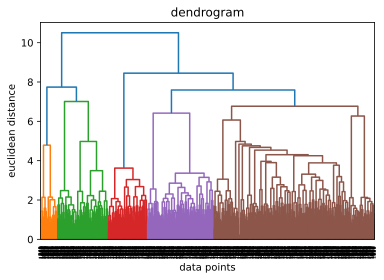

In [11]:
Z = sch.linkage(tfidf_df, method='ward', metric='euclidean', optimal_ordering=False)  # 沃德方差最小化,欧氏距离
#y = fcluster(Z,4,criterion='distance')
dendrogram = sch.dendrogram(Z)
plt.xlabel('data points')
plt.ylabel('euclidean distance')
plt.title('dendrogram')
plt.savefig('./pictures/dendrogram.png', dpi=500, bbox_inches='tight')

# kmeans

## 手肘法找最佳聚类数

D:\software\Anaconda3\envs\datamining\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(


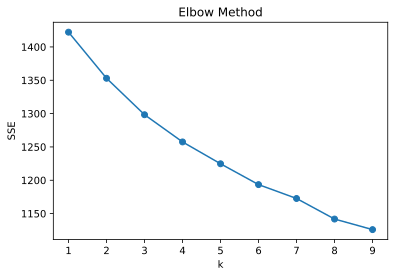

In [12]:
SSE = []  # 簇内误方差
K = range(1, 10)
for k in K:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(tfidf_df)  # fit训练向量化后的文本数据
    SSE.append(kmeans.inertia_)  # 获取聚类准总和
plt.xlabel('k')
plt.ylabel('SSE')
plt.title('Elbow Method')
plt.plot(K, SSE, 'o-')
plt.savefig('./pictures/k_SSE.png', dpi=500, bbox_inches='tight')

## kmean模型搭建

In [13]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(tfidf_df)
cluster = kmeans.predict(tfidf_df)
news_data_df['obtained_clusters'] = cluster
news_data_df

,text,category,cleaned_text,obtained_clusters
0,From: atom@netcom.com (Allen Tom)\nSubject: Re...,1,atom netcom com allen tom subject re dumb opti...,0
1,From: wtm@uhura.neoucom.edu (Bill Mayhew)\nSub...,2,wtm uhura neoucom edu bill mayhew subject re d...,1
2,From: corwin@igc.apc.org (Corwin Nichols)\nSub...,2,corwin igc apc org corwin nichols subject re f...,1
3,From: A.D.Bailey@lut.ac.uk\nSubject: Re: Utili...,0,bailey lut ac uk subject re utility updating w...,2
4,From: mobasser@vu-vlsi.ee.vill.edu (Bijan Moba...,1,mobasser vu vlsi ee vill edu bijan mobasseri s...,1
...,...,...,...,...
1771,From: dbd@icf.hrb.com (Douglas B. Dodson)\nSub...,0,dbd icf hrb com douglas dodson subject window ...,2
1772,From: marshatt@feserve.cc.purdue.edu (Zauberer...,1,marshatt feserve cc purdue edu zauberer subjec...,0
1773,From: hzhang@compstat.wharton.upenn.edu (Hao Z...,0,hzhang compstat wharton upenn edu hao zhang su...,1
1774,From: ip02@ns1.cc.lehigh.edu (Danny Phornpraph...,1,ip02 ns1 cc lehigh edu danny phornprapha subje...,1


## 交叉表显示聚类结果

In [14]:
pd.crosstab(news_data_df['category'].replace({0: 'comp.os.ms-windows.misc', 1:  'rec.autos', 2: 'sci.electronics'}),
            news_data_df['obtained_clusters'].replace({0: 'cluster1', 1: 'cluster2', 2: 'cluster3', 3: 'cluster4', 5:'cluster5'}))

obtained_clusters,cluster1,cluster2,cluster3
category,,,
comp.os.ms-windows.misc,43,165,383
rec.autos,367,223,4
sci.electronics,183,401,7
